In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

/tmp/ipykernel_1701/2706930054.py:3: RuntimeWarning: divide by zero encountered in divide
  Cl = (W/(0.5*rho*x*x*S))
/tmp/ipykernel_1701/2706930054.py:5: RuntimeWarning: invalid value encountered in multiply
  D = Cd *(0.5*rho*x*x*S)


Maximum value: 9.378944199669501
At x = 18.658854378175743


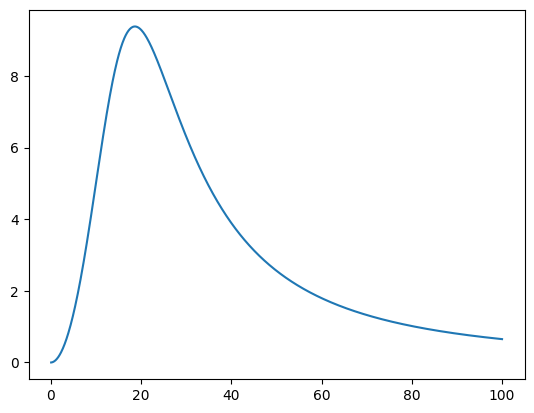

In [62]:
def f(x,W,Cd0,rho,S,AR,e):
    L = W
    Cl = (W/(0.5*rho*x*x*S))
    Cd = Cd0+((Cl*Cl)/(e*AR*(np.pi)))
    D = Cd *(0.5*rho*x*x*S)
    return L/D

x = np.linspace(0, 100, 1000)
y= f(x,200,0.05,1.225,1,7,0.8)
plt.plot(x,y)

print("Maximum value:", max_value)
print("At x =", max_x)

In [63]:
air_density = 1.225  # kg/m³
tolerance = 1e-5


In [64]:
# Constants based on the materials and various performance factors
power_margin = 0.20  #  percentage or amount of extra power that the motor can provide
SoC_min = 0.20  # It’s a percentage of the battery’s total capacity that remains unused to extend battery life and maintain performance.
battery_efficiency = 0.85
figure_of_merit = 0.75  # FM serves as an indicator of rotor efficiency.
battery_energy_density = 200  # Wh/kg
eta_prop = 0.85  # Propeller efficiency


In [133]:
# Flight performance and mission requirements for the drone
vertical_climb_velocity = 10  # m/s
vertical_descent_velocity = -10 # m/s
cruise_speed = 10  # m/s
payload = 4  # kg
range_km = 30  # km

# Mission Profile
cruise_height = 1000  # m
bomb_drop_height = 20  # m
bomb_drop_hovering_time = 3  # minutes


In [147]:
# Aircraft specifications and design parameters
wing_area = 0.67  # m²
wing_density =1600 # kg/m^3
disk_loading = 200 # N/m^2
fuselage_length = 0.5  # m
max_fuselage_perimeter = 1.5  # m
num_motors = 4  # Example number of motors
Cd_not = 0.04  # parasite drag
AR = 7 # aspect ratio
e = 0.84  # Oswald efficiency factor
design_load_factor = 29.43  # 3g

In [148]:
def calculate_wingless_mass_iterative(
    vertical_climb_velocity=10,
    cruise_speed=25,
    range_km=30,
):
    max_iterations = 1000
    current_guess = 50  # Start with a lower initial guess for total mass (kg)

    def calculate_sub_masses(m_total):
        """Calculates all dependent masses based on the current guess of total mass"""

        # 1. Hover Power Calculation (for takeoff and landing)
        thrust = m_total * 9.81

        # Check for reasonable thrust and prevent overflow
        if thrust <= 0:
            raise ValueError("Thrust must be positive.")

        rotor_area = thrust / (4 * disk_loading)  # Simplified rotor area
        rotor_dia = 2*np.sqrt(rotor_area/np.pi)
        rod_length = rotor_dia + 2.4 * rotor_dia +rotor_dia
        hover_velocity = np.sqrt(thrust / (2 * air_density * rotor_area))
        hover_power = thrust * hover_velocity

        # 2. Climb Power Calculation (Climb Power to Hover Power Ratio)
        climb_power_ratio = (
            (vertical_climb_velocity / (2 * hover_velocity))
        ) + math.sqrt(((vertical_climb_velocity / (2 * hover_velocity)) ** 2) + 1)
        climb_power = climb_power_ratio * hover_power

        # 3. Cruise Power Calculation for Powered-Lift
        area = 0.05
        drag_coefficient = Cd_not +0.07
        drag_force = (
            0.5 * air_density * (cruise_speed**2) * area * drag_coefficient
        )
        alpha = np.arctan(thrust/drag_force)
        t_req = thrust/(np.sin(alpha))
        cruise_power = t_req *cruise_speed

        # 4. Descent Power Calculation (Descent Power to Hover Power Ratio)
        descent_power_ratio = vertical_descent_velocity / hover_velocity
        descent_power = hover_power
        if descent_power_ratio <= -2:
            descent_power = (
                (descent_power_ratio / 2)
                + math.sqrt(((descent_power_ratio / 2) ** 2) - 1)
            ) * hover_power

        # Energy consumption for each phase
        climb_duration = cruise_height / (vertical_climb_velocity * 60 * 60)
        descent_duration = climb_duration

        bomb_drop_descent_duration = (cruise_height - bomb_drop_height) / (
            (vertical_climb_velocity + 5) * 60 * 60
        )
        bomb_drop_climb_duration = bomb_drop_descent_duration
        cruise_duration = (range_km * 1000) / (cruise_speed * 60 * 60)  # in hrs

        # Energy consumption for each phase
        hover_energy = hover_power * (bomb_drop_hovering_time / 60)
        climb_energy = climb_power * (climb_duration + bomb_drop_climb_duration)
        cruise_energy = cruise_power * cruise_duration
        descent_energy = descent_power * (descent_duration + bomb_drop_descent_duration)
        total_energy = hover_energy + climb_energy + cruise_energy + descent_energy
        # print(hover_energy, climb_energy, cruise_energy, descent_energy)
        # Battery mass calculation using Page 11 formula
        m_battery = (
            total_energy * (1 + SoC_min) / (battery_energy_density * battery_efficiency)
        )
        # print(m_battery)
        # Airframe mass using fuselage formula
        fuselage_length = 0.2
        m_airframe = (
            14.86
            * (m_total**0.144)
            * (fuselage_length**0.778)
            * (fuselage_length**0.383)
        ) / (max_fuselage_perimeter)

        m_rod = 2*(
            1600 * np.pi * rod_length * (0.36/10000)
        )
        # Motor mass calculation
        m_motor = 4*(0.165 * (climb_power * (1 + power_margin)) / (num_motors * 1000))
        # print(m_wing, m_motor, m_airframe)
        return (
            m_battery,
            m_airframe,
            m_motor,
            m_rod,
            drag_force,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
        )

    for i in range(max_iterations):
        (
            m_battery,
            m_airframe,
            m_motor,
            m_rod,
            drag_force,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
        ) = calculate_sub_masses(current_guess)

        # New total mass estimate
        new_total_mass = m_battery + m_airframe + m_motor + payload +m_rod

        # Convergence check
        if abs(new_total_mass - current_guess) < tolerance:
            break
        current_guess = new_total_mass

        # Optional: Limit the maximum mass to prevent overflow
        if current_guess > 5000:  # Set a reasonable upper limit for total mass (kg)
            raise ValueError("Total mass exceeds reasonable limits.")
    return (
        current_guess,
        m_battery,
        m_airframe,
        m_motor,
        m_rod,
        drag_force,
        hover_power,
        climb_power,
        cruise_power,
        descent_power,
        total_energy,
    )


In [151]:
def calculate_powered_lift_mass_iterative(
    vertical_climb_velocity=10,
    cruise_speed=25,
    range_km=30,
    wing_area = wing_area
):
    max_iterations = 1000
    current_guess = 50  # Start with a lower initial guess for total mass (kg)
    vertical_climb_velocity =10
    def calculate_sub_masses(m_total):
        """Calculates all dependent masses based on the current guess of total mass"""

        # 1. Hover Power Calculation (for takeoff and landing)
        thrust = m_total * 9.81

        # Check for reasonable thrust and prevent overflow
        if thrust <= 0:
            raise ValueError("Thrust must be positive.")

        rotor_area = thrust / (4 * disk_loading)  # Simplified rotor area
        rotor_dia = 2*np.sqrt(rotor_area/np.pi)
        hover_velocity = np.sqrt((thrust) / (2 * air_density* rotor_area ))
        hover_power = thrust * hover_velocity

        # 2. Climb Power Calculation (Climb Power to Hover Power Ratio)
        climb_power_ratio = (
            (vertical_climb_velocity / (2 * hover_velocity))
        ) + math.sqrt(((vertical_climb_velocity / (2 * hover_velocity)) ** 2) + 1)
        climb_power = (climb_power_ratio * hover_power)
        
        dl = climb_power/(vertical_climb_velocity*4*rotor_area)
        v_stall = np.sqrt(thrust/(0.5*air_density*1.5))
        # 3. Cruise Power Calculation for Powered-Lift
        result = minimize_scalar(lambda x: -f(x,thrust,Cd_not,air_density,wing_area,AR,e))
        max_value = f(result.x,thrust,Cd_not,air_density,wing_area,AR,e)
        cruise_speed = result.x
        Cl = thrust / (0.5 * air_density * (cruise_speed**2) * wing_area)
        drag_coefficient = Cd_not + (
            (Cl**2) / (np.pi * e * AR)
        )  # Total drag coefficient
        drag_force = (
            0.5 * air_density * (cruise_speed**2) * wing_area * drag_coefficient
        )
        cruise_power = (drag_force * cruise_speed) / eta_prop

        # 4. Descent Power Calculation (Descent Power to Hover Power Ratio)
        descent_power_ratio = vertical_descent_velocity / hover_velocity
        descent_power = hover_power
        if descent_power_ratio <= -2:
            descent_power = (
                (descent_power_ratio / 2)
                + math.sqrt(((descent_power_ratio / 2) ** 2) - 1)
            ) * hover_power

        # Energy consumption for each phase
        climb_duration = cruise_height / (vertical_climb_velocity * 60 * 60)
        descent_duration = climb_duration

        bomb_drop_descent_duration = (cruise_height - bomb_drop_height) / (
            (vertical_climb_velocity + 5) * 60 * 60
        )
        bomb_drop_climb_duration = bomb_drop_descent_duration
        cruise_duration = (range_km * 1000) / (cruise_speed * 60 * 60)  # in hrs

        # Energy consumption for each phase
        hover_energy = hover_power * (bomb_drop_hovering_time / 60)
        climb_energy = climb_power * (climb_duration + bomb_drop_climb_duration)
        cruise_energy = cruise_power * cruise_duration
        descent_energy = descent_power * (descent_duration + bomb_drop_descent_duration)
        total_energy = hover_energy + climb_energy + cruise_energy + descent_energy
        # print(hover_energy, climb_energy, cruise_energy, descent_energy)
        # Battery mass calculation using Page 11 formula
        m_battery = (
            total_energy * (1 + SoC_min) / (battery_energy_density * battery_efficiency)
        )
        # print(m_battery)
        # Airframe mass using fuselage formula

        m_airframe = (
            14.86
            * (m_total**0.144)
            * (fuselage_length**0.778)
            * (fuselage_length**0.383)
        ) / (max_fuselage_perimeter)

        m_wing = (
            0.04647
            * (m_total**0.397)
            * (wing_area**0.360)
            * (design_load_factor**0.397)
            * (AR**1.2)
        )
        # Motor mass calculation
        m_motor = 4*(0.165 * (climb_power * (1 + power_margin)) / (num_motors * 1000))
        

        # print(m_wing, m_motor, m_airframe)
        return (
            m_battery,
            m_airframe,
            m_motor,
            m_wing,
            drag_force,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
            rotor_dia,
            cruise_speed,
            dl,
            v_stall
        )

    for i in range(max_iterations):
        (
            m_battery,
            m_airframe,
            m_motor,
            m_wing,
            drag_force,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
            rotor_dia,
            cruise_speed,
            dl,
            v_stall
        ) = calculate_sub_masses(current_guess)

        # New total mass estimate
        m_propeller = 0.2 # kg
        new_total_mass = m_battery + m_airframe + m_motor + m_propeller + payload + m_wing
        diff = abs(new_total_mass - current_guess)
        # Convergence check
        if abs(new_total_mass - current_guess) < tolerance:
            break
        current_guess = new_total_mass

        # Optional: Limit the maximum mass to prevent overflow
        if current_guess > 5000:  # Set a reasonable upper limit for total mass (kg)
            raise ValueError("Total mass exceeds reasonable limits.")
    return (
        current_guess,
        m_battery,
        m_airframe,
        m_motor,
        m_propeller,
        m_wing,
        drag_force,
        hover_power,
        climb_power,
        cruise_power,
        descent_power,
        total_energy,
        diff,
        rotor_dia, 
        cruise_speed 
        ,dl,
        v_stall
    )


In [152]:
(
    total_mass,
    m_battery,
    m_airframe,
    m_motor,
    m_propeller,
    m_wing,
    drag_force,
    hover_power,
    climb_power,
    cruise_power,
    descent_power,
    total_energy,
    diff,
    rotor_dia,
    speed,
    load,
    stall_speed
) = calculate_powered_lift_mass_iterative()

# Print the values with descriptive labels
print("Total Mass:", total_mass, "kg")
print("Battery Mass:", m_battery, "kg")
print("Airframe Mass:", m_airframe, "kg")
print("Motor Mass:", m_motor, "kg")
print("Propeller Mass:", m_propeller, "kg")
print("Wing Mass:", m_wing, "kg")
print("Total Drag", drag_force, "N")
print("Hover Power:", hover_power, "W")
print("Climb Power:", climb_power, "W")
print("Cruise Power:", cruise_power, "W")
print("Descent Power:", descent_power, "W")
print("Total Energy:", total_energy, "Wh")
print("battery fraction:", round(m_battery/total_mass,2))
print("Airframe fraction:", round(m_airframe/total_mass,2))
print("Motor fraction:", round(m_motor/total_mass,2))
print("Propeller fraction:", round(m_propeller/total_mass,2))
print("Wing fraction:", round(m_wing/total_mass,2))
print("payload fraction: ", round(payload/total_mass,2))
print("diff :", diff)
print("Rotor Diameter: ",rotor_dia)
print("cruise speed:", speed)
print("disk loading :", load)
print("stall speed :", stall_speed)

Total Mass: 24.246583667687542 kg
Battery Mass: 6.273636508148805 kg
Airframe Mass: 7.011668987365527 kg
Motor Mass: 1.1184918320359865 kg
Propeller Mass: 0.2 kg
Wing Mass: 5.642781762084849 kg
Total Drag 22.136856748723076 N
Hover Power: 4298.149468585422 W
Climb Power: 5648.948646646395 W
Cruise Power: 676.2691320136053 W
Descent Power: 4298.149468585422 W
Total Energy: 888.7651719877473 Wh
battery fraction: 0.26
Airframe fraction: 0.29
Motor fraction: 0.05
Propeller fraction: 0.01
Wing fraction: 0.23
payload fraction:  0.16
diff : 4.578052376302821e-06
Rotor Diameter:  0.6152758190089563
cruise speed: 25.96704530984158
disk loading : 474.9829928116196
stall speed : 16.09018751234208


/tmp/ipykernel_1701/2706930054.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  Cl = (W/(0.5*rho*x*x*S))
/tmp/ipykernel_1701/2706930054.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  D = Cd *(0.5*rho*x*x*S)


In [144]:
(
    total_mass,
    m_battery,
    m_airframe,
    m_motor,
    m_rod,
    drag_force,
    hover_power,
    climb_power,
    cruise_power,
    descent_power,
    total_energy,
    # speed,
) = calculate_wingless_mass_iterative()

# Print the values with descriptive labels
print("Total Mass:", total_mass, "kg")
print("Battery Mass:", m_battery, "kg")
print("Airframe Mass:", m_airframe, "kg")
print("Motor Mass:", m_motor, "kg")
print("rod Mass:", m_rod, "kg")
print("Total Drag", drag_force, "N")
print("Hover Power:", hover_power, "W")
print("Climb Power:", climb_power, "W")
print("Cruise Power:", cruise_power, "W")
print("Descent Power:", descent_power, "W")
print("Total Energy:", total_energy, "Wh")
print("battery fraction:", m_battery/total_mass)
print("Airframe fraction:", m_airframe/total_mass)
print("Motor fraction:", m_motor/total_mass)
print("Rod fraction:", m_rod/total_mass)
print("payload fraction:", payload/total_mass)


Total Mass: 33.75051342553903 kg
Battery Mass: 24.350438325360862 kg
Airframe Mass: 2.538024152347529 kg
Motor Mass: 1.2272786313974466 kg
rod Mass: 1.6347629544145434 kg
Total Drag 2.1054687500000004 N
Hover Power: 4230.545250938234 W
Climb Power: 6198.37692624973 W
Cruise Power: 8277.48077844729 W
Descent Power: 4230.545250938234 W
Total Energy: 3449.645429426122 Wh
battery fraction: 0.7214834932536129
Airframe fraction: 0.07519957164346437
Motor fraction: 0.036363258120653184
Rod fraction: 0.048436684023227844
payload fraction: 0.11851671557011627


/tmp/ipykernel_1701/2706930054.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  Cl = (W/(0.5*rho*x*x*S))
/tmp/ipykernel_1701/2706930054.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  D = Cd *(0.5*rho*x*x*S)


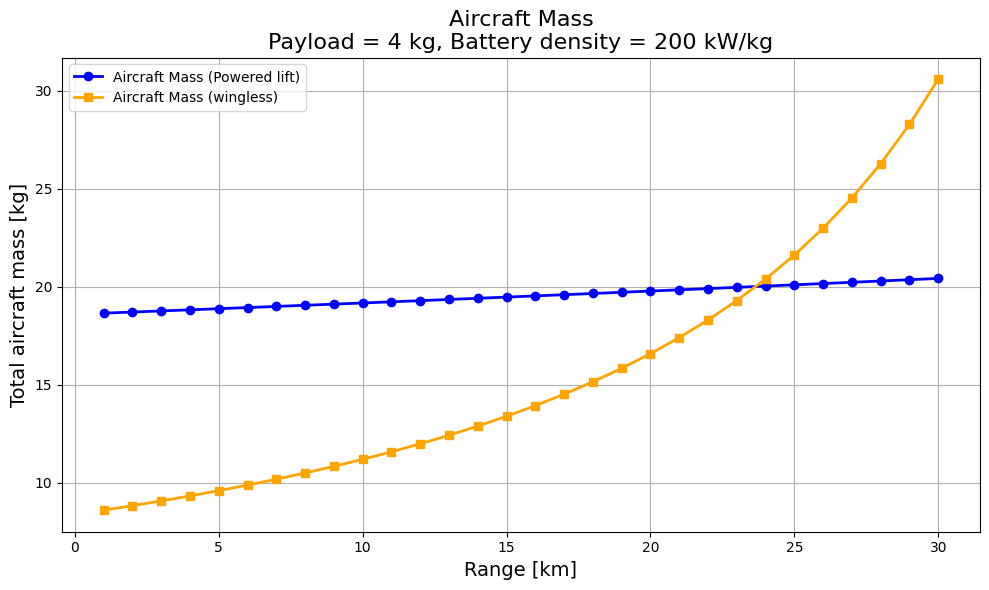

In [71]:
r = np.linspace(1,30,30)
mass_wingless  = np.array([])
mass_wing  = np.array([])
for i in range(len(r)):
    mass_wingless =np.append(mass_wingless,calculate_wingless_mass_iterative(range_km=r[i])[0])
    mass_wing =np.append(mass_wing,calculate_powered_lift_mass_iterative(range_km=r[i])[0])

plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the data
plt.plot(r, mass_wing, label='Aircraft Mass (Powered lift)', color='blue', linewidth=2, marker='o')
plt.plot(r, mass_wingless, label='Aircraft Mass (wingless)', color='orange', linewidth=2, marker='s')

# Add labels and title
plt.title('Aircraft Mass\nPayload = 4 kg, Battery density = 200 kW/kg', fontsize=16)
plt.xlabel('Range [km]', fontsize=14)
plt.ylabel('Total aircraft mass [kg]', fontsize=14)

# Add a legend
plt.legend()

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [72]:
def plot_range_vs_mass():
    # Define a range of distances (in kilometers) to evaluate
    ranges = np.linspace(10, 50, 10)  # From 10 km to 500 km
    masses = []
    for range_km in ranges:
        (
            mass,
            m_battery,
            m_airframe,
            m_motor,
            m_wing,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
        ) = calculate_powered_lift_mass_iterative(
            vertical_climb_velocity, cruise_speed, range_km
        )
        masses.append(mass)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(ranges, masses, label="Take-Off Gross Weight vs Range", color="b")
    plt.title("Range vs Take-Off Gross Weight for Powered-Lift eVTOL")
    plt.xlabel("Range (km)")
    plt.ylabel("Take-Off Gross Weight (kg)")
    plt.grid()
    plt.legend()
    plt.show()

def plot_range_vs_energy():
    # Define a range of distances (in kilometers) to evaluate
    ranges = np.linspace(10, 50, 10)  # From 10 km to 500 km
    masses = []
    for range_km in ranges:
        (
            mass,
            m_battery,
            m_airframe,
            m_motor,
            m_wing,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
        ) = calculate_powered_lift_mass_iterative(
            vertical_climb_velocity, cruise_speed, range_km
        )
        masses.append(total_energy)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(ranges, masses, label="Take-Off Gross Weight vs Range", color="b")
    plt.title("Energy vs Take-Off Gross Weight for Powered-Lift eVTOL")
    plt.xlabel("Range (km)")
    plt.ylabel("Energy(Wh)")
    plt.grid()
    plt.legend()
    plt.show()


In [240]:
plot_range_vs_mass()
plot_range_vs_energy()


ValueError: Total mass exceeds reasonable limits.

In [174]:
def plot_cruise_power_vs_velocity():
    # Define a range of distances (in kilometers) to evaluate
    velocities = np.linspace(20, 50, 10)  # From 10 m/s to 500 m/s
    powers = []
    for velocity in velocities:
        (
            total_mass,
            m_battery,
            m_airframe,
            m_motor,
            m_wing,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
        ) = calculate_powered_lift_mass_iterative(vertical_climb_velocity, velocity, range_km)
        powers.append(cruise_power)
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(velocities, powers, label="Cruise Power vs cruise Velocity", color="b")
    plt.title("Cruise Power vs Cruise Velocity")
    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Power (W)")
    plt.grid()
    plt.legend()
    plt.show()


1409.9379588916902
1167.4811123449467
1086.7966692115094
1092.7522786400596
1160.582176134862
1280.6776934630495
1449.444945057245
1666.1059059876254
1931.3622841132562
2246.7567688900067


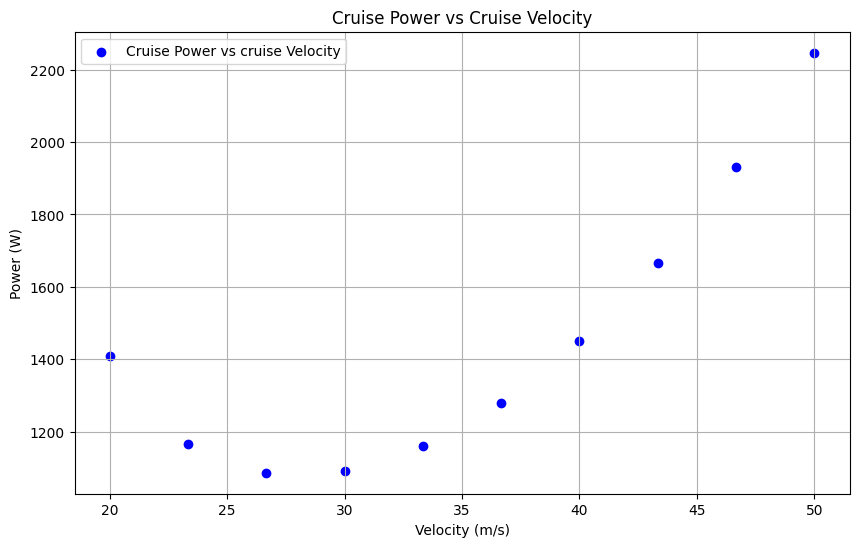

In [175]:
plot_cruise_power_vs_velocity()


In [176]:
def plot_energy_vs_range():
    # Define a range of distances (in kilometers) to evaluate
    range = np.linspace(10, 50, 20)  # From 10 m/s to 500 m/s
    powers = []
    for velocity in velocities:
        (
            total_mass,
            m_battery,
            m_airframe,
            m_motor,
            m_wing,
            hover_power,
            climb_power,
            cruise_power,
            descent_power,
            total_energy,
        ) = calculate_powered_lift_mass_iterative(
            velocity, cruise_speed, range_km, 1e-5
        )
        powers.append(cruise_power)
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(velocities, powers, label="Climb Power vs Vertical Velocity", color="b")
    plt.title("Climb Power vs Vertical Velocity")
    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Power (W)")
    plt.grid()
    plt.legend()
    plt.show()


1113.61208359994
1050.5342797173112
1009.676927779218
981.2582871891866
960.523848987634
944.8765868704284
932.7779801087066
923.2568392452633
915.6673638653497
909.5657526234215
904.6351786471937
900.6436115766318
897.4171392521843
894.8227867639023
892.757104471885
891.1383817904953
889.9012083492235
888.9925950099753
888.369155642312
887.995025279509


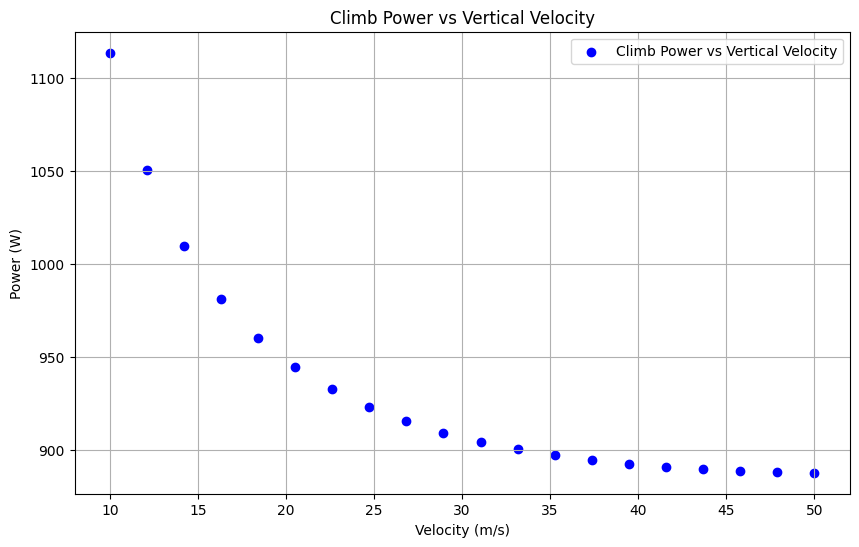

In [173]:
plot_climb_power_vs_velocity()

In [247]:
def plot_TbyW_vs_WbyS():
    # Define a range of distances (in kilometers) to evaluate
    plt.figure(figsize=(10, 6))
    v = np.linspace(25,25,1)
    
    for velocity in v:
        s = np.linspace(1, 4, 50)  
        y = []  # T/W
        x = []  # W/S
        
        for area in s:
            (
                total_mass,
                m_battery,
                m_airframe,
                m_motor,
                m_propeller,
                m_wing,
                drag_force,
                hover_power,
                climb_power,
                cruise_power,
                descent_power,
                total_energy,
                diff,
                rotor_dia
            ) = calculate_powered_lift_mass_iterative(
                10, velocity, 30, area
            )
            # Calculate T/W and W/S
            T_over_W = drag_force / (total_mass * 9.81)  # T/W ratio
            W_over_S = (total_mass * 9.81) / area  # W/S ratio
            
            y.append(T_over_W)
            x.append(W_over_S)
            print(area, total_mass, "\n")
        
        # Plotting
        plt.scatter(x, y, label=f"Velocity: {velocity} m/s")
    
    # Finalizing the plot
    plt.title("Thrust-to-Weight Ratio (T/W) vs Wing Loading (W/S)")
    plt.xlabel("Wing Loading (W/S) [N/m²]")
    plt.ylabel("Thrust-to-Weight Ratio (T/W)")
    plt.grid()
    plt.legend()
    plt.show()

1.0 24.614123752908327 

1.0612244897959184 24.932958176957232 

1.1224489795918366 25.247533223968656 

1.183673469387755 25.558018531058064 

1.2448979591836735 25.864589579967003 

1.306122448979592 26.167421294350234 

1.3673469387755102 26.46668422916042 

1.4285714285714286 26.762542386761954 

1.489795918367347 27.055152059564513 

1.5510204081632653 27.344661320508255 

1.6122448979591837 27.631209919695188 

1.6734693877551021 27.914929431528957 

1.7346938775510203 28.19594355157669 

1.7959183673469388 28.474368477741173 

1.8571428571428572 28.750313333372727 

1.9183673469387754 29.023880605072826 

1.9795918367346939 29.295166577924896 

2.0408163265306123 29.564261757497594 

2.1020408163265305 29.83125127234606 

2.163265306122449 30.09621525362965 

2.2244897959183674 30.35922919036269 

2.2857142857142856 30.620364260043118 

2.3469387755102042 30.879687635181337 

2.4081632653061225 31.13726276672591 

2.4693877551020407 31.393159523503165 

2.5306122448979593 31.647

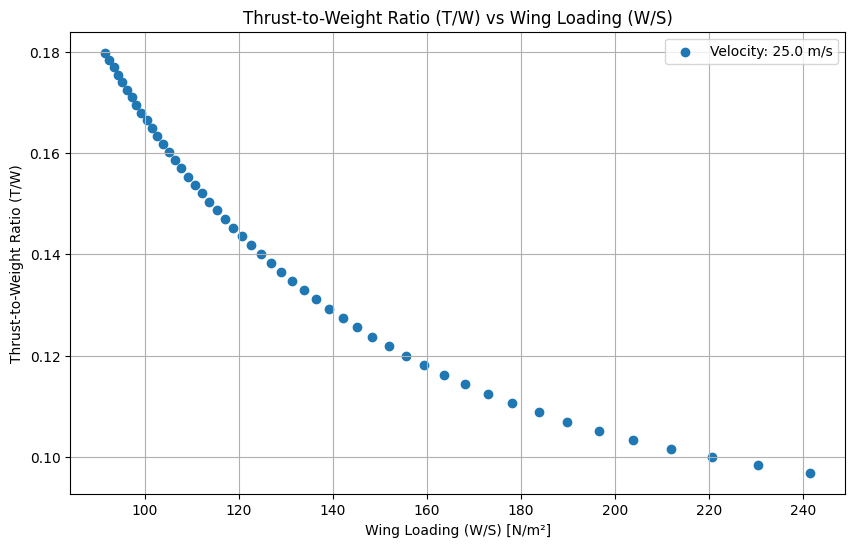

In [248]:
plot_TbyW_vs_WbyS()